In [5]:
%pylab inline
rcParams["savefig.dpi"] = 120


Populating the interactive namespace from numpy and matplotlib


In [1]:
from joblib import Memory

cache = Memory("wd/mem/")
import xarray as xr
import gnl.xcalc
from gnl.plots import plotiter
from lib.wave import Wave
from lib.multiscale import Averager

import yaml
config  = yaml.load(open("config.yaml"))

run = config['runs']['8aa7b']

In [3]:
data = xr.open_dataset("wd/8aa7b/nondim.nc")
# data2d = xr.open_dataset("wd/8aa7b/coarse2d.nc")

## Wave frame averages

Let's plot some wave-frame averages for the meso-scale, synoptic-scale, and planetary-scale waves.

### Planetary scale flow

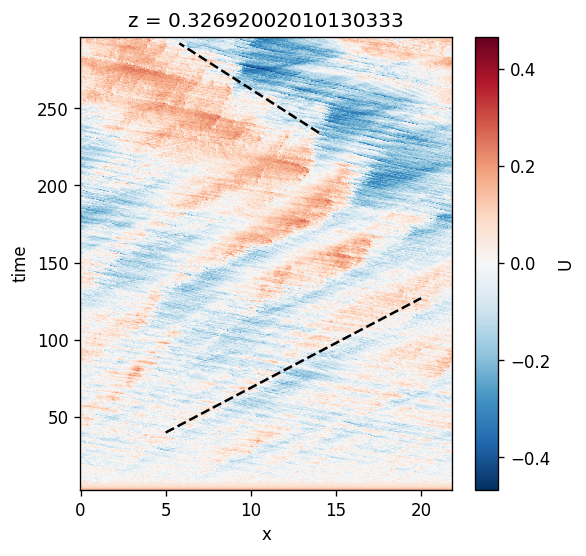

In [74]:
u10 = data.U.isel(z=10)

plt.figure(figsize=(5,5))
(u10+10/51).plot()

for w,coords in run['waves'].items():
    wave = Wave(coords)
    plt.plot(*wave.pts, 'k--')

In [75]:
@cache.cache()
def get_wave_avg(wave, data):
    wave = Wave(wave)
    avg = data.apply(lambda x: wave.average(x)[0] if set(x.dims) > {'x', 'time'} else x)
    return avg

avg = get_wave_avg(run['waves']['A'], data).sel(z=slice(0,2.5))

This is the wave-frame average of the planetary scale flow. 

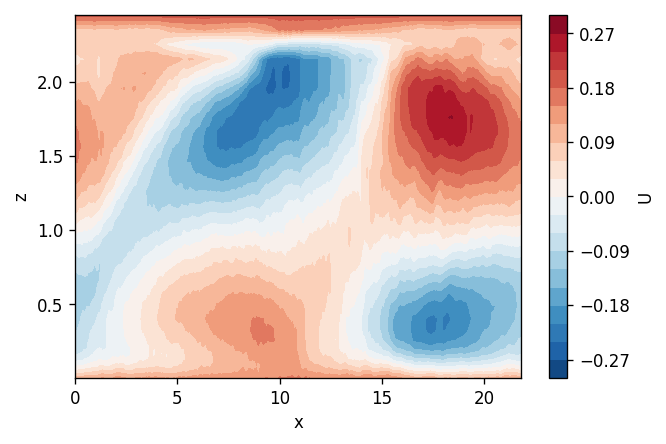

In [76]:
(avg.U+10/51).plot.contourf(levels=21)

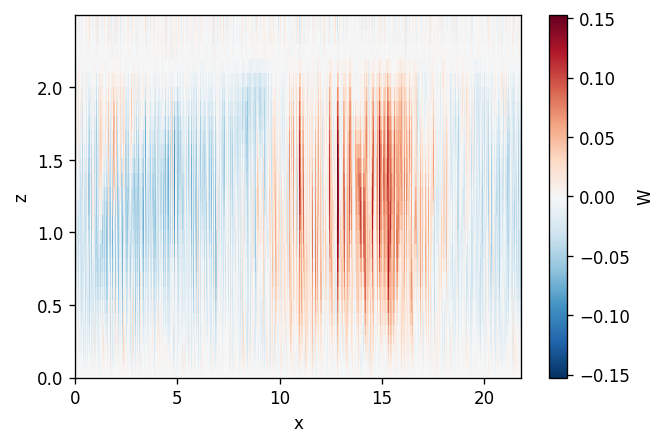

In [77]:
avg.W.plot()

In [78]:
avg.B.sel(z=slice(0,2)).plot()

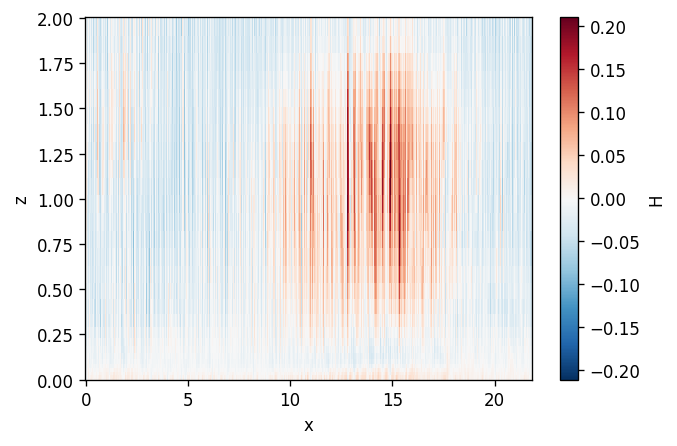

In [79]:
avg.H.sel(z=slice(0,2)).plot()

### Synoptic scale

In [80]:
avg = get_wave_avg(run['waves']['B'], data).sel(z=slice(0,2.5), x=slice(2, 10.0))

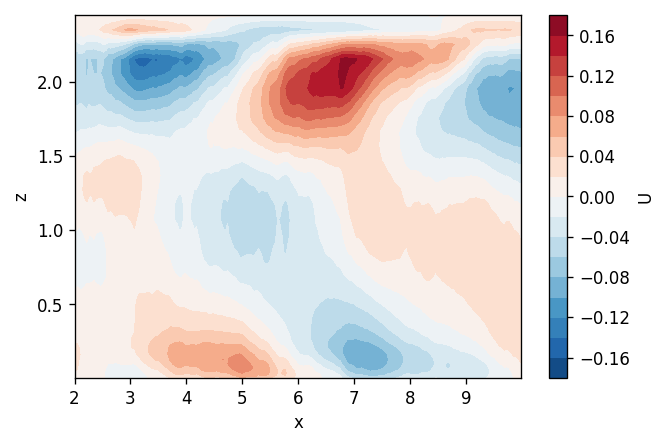

In [87]:
(avg.U-avg.U.mean('x')).plot.contourf(levels=21)

In [88]:
(avg.B-avg.B.mean('x')).sel(z=slice(0,2)).plot.contourf(levels=15)

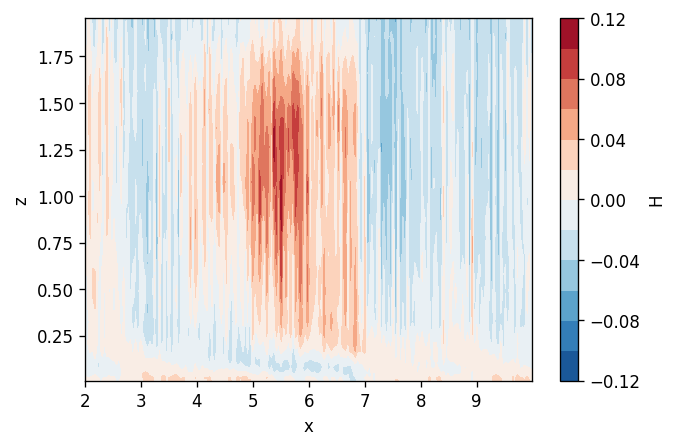

In [83]:
avg.H.sel(z=slice(0,2)).plot.contourf(levels=15)

### Spline based-decomposition

Plotting a snapshot of the simulation at $t=175$ is useful. In all of these cases.

In [ ]:
ms = xr.open_dataset("wd/8aa7b/nondim.multiscale.nc")

In [ ]:
def this_sel(A):

     return A\
    .sel(z=slice(0,2.2))\
    .sel(time=175, method='nearest')

In [ ]:
this_sel(ms.U).plot.contourf(levels=21, col='scale')

## Stream functions

In [9]:
moms =  xr.open_dataset("wd/8aa7b/moments.nc")
rho = xr.open_dataset("wd/8aa7b/stat.nc").RHO.isel(time=0)

### Verifying the divergence free conditions

The divergence free condition is not satisfied by the input data. This is probably because all the data are defined at the cell centers.

In [10]:
div_x = (moms.U1*rho).chunk().centderiv('x').isel(time=500).sel(z=slice(0,1.1e3))
div_z = (moms.W1 * rho).chunk().centderiv('z', boundary='extrap').isel(time=500).sel(z=slice(0,1.1e3))

In [11]:
plt.figure(figsize=(6,2))
plt.subplot(121)
div_x.plot()
plt.subplot(122)
div_z.plot()

plt.tight_layout()

Therefore, we will use the horizontal velocity field to define a streamfunction given by
$\psi = \int u \rho_0 dz + C(x)$. The free constant $C$ is defined so that $\psi =0 $ if $z=0$.

In [4]:
weight = xr.open_dataset("wd/8aa7b/adz.nc").adz

In [5]:
psi = (weight * (moms.U1-moms.U1.mean('x'))).cumsum('z')
psi -= psi.isel(z=0)

NameError: name 'moms' is not defined

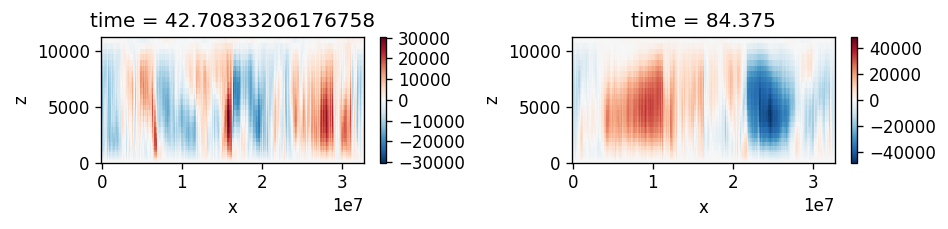

In [71]:

for t in plotiter([1000, 2000], aspect=0.5, w=4, title=True):
    psi.sel(z=slice(0,11e3)).isel(time=t).plot()

The simulations become organized on the largest scale as time progresses.

### multiscale decomposition of the stream function

In [4]:
ms = xr.open_dataset("wd/8aa7b/nondim.multiscale.nc")

In [4]:
ms.psi.isel(z=10).plot(col='scale', aspect=.5)

The results appear largely similar to multiscale decomposition of the horizontal velocity.

In [6]:
b10 = ms.B.sel(scale='s')

In [7]:
b_syn_x = b10.centderiv('x')

u_syn_zt = ms.U.sel(scale='s')\
.centderiv('z', boundary='extrap')\
.centderiv('time', boundary='extrap')

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/core.py:457: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)


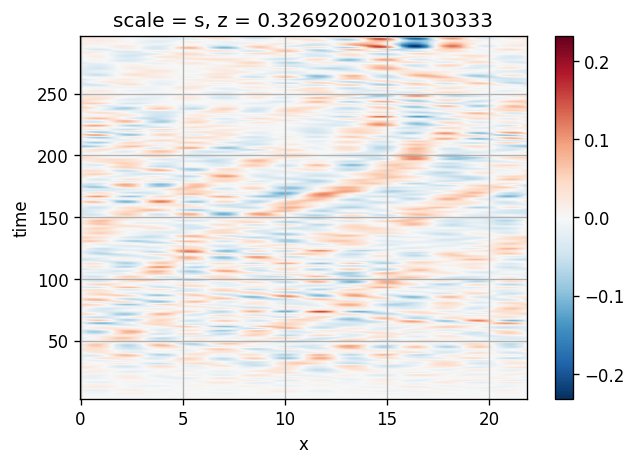

In [11]:
b_syn_x.isel(z=10).plot()
plt.grid()

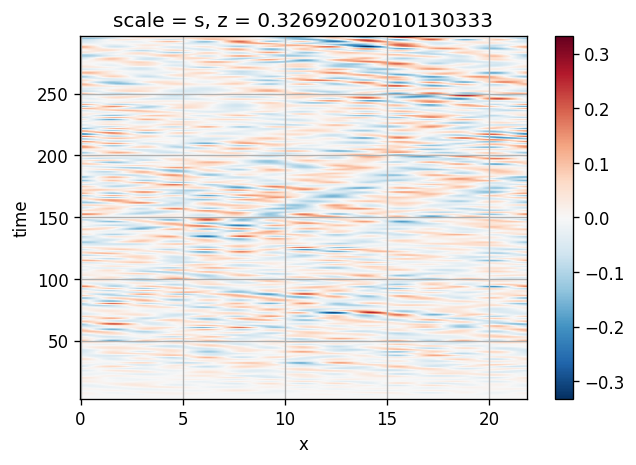

In [12]:
u_syn_zt.isel(z=10).plot()
plt.grid()

There seems to be a good amount of balance between $u_{zt}$ and $\theta_{x}$. I might want to use a higher order spline to get rid of the patchiness in the data.

## Higher order spline derivatives

In [43]:
data = xr.open_dataset("wd/8aa7b/nondim.nc").sel(time=slice(100,200))

avg = Averager.from_dataset(data, l_s=2.0)

b_syn_x = avg.msdecomp(data.B).sel(scale='s').centderiv('x').isel(z=10).compute()
u_syn_zt = avg.msdecomp(data.U).sel(scale='s').centderiv('time').centderiv('z').isel(z=10).compute()

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/core.py:457: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)


KeyboardInterrupt: 

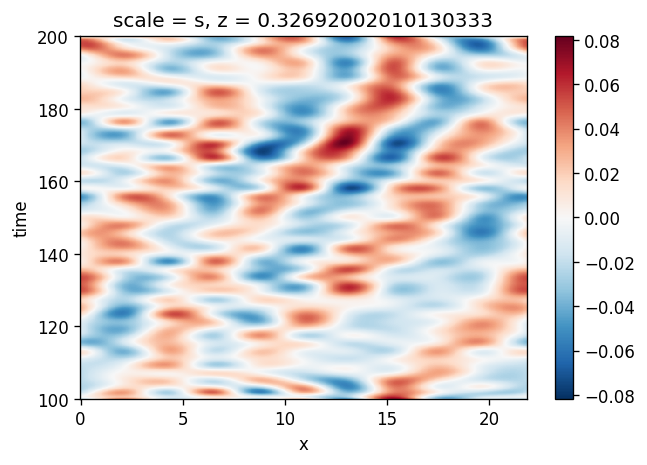

In [33]:
b_syn_x.plot()

In [34]:
beta = b_syn_x.dot(u_syn_zt)/b_syn_x.dot(b_syn_x)
np.asarray(beta)

array(-0.8138056660313999)

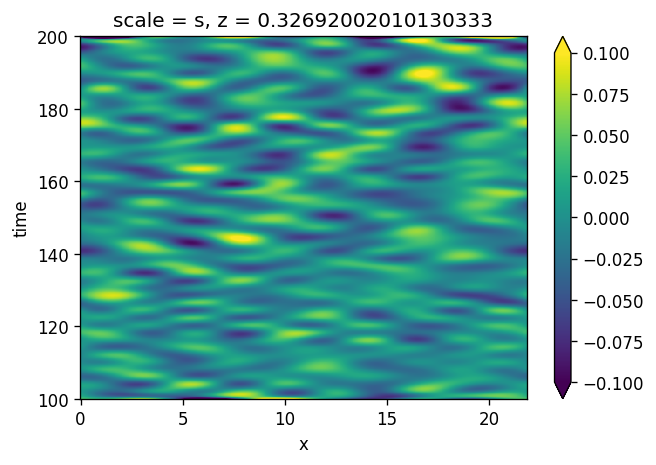

In [35]:
(b_syn_x *beta- u_syn_zt).plot(vmin=-.1, vmax=.1)